In [246]:
import os
from binance import Client
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import talib as ta
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import time 
from datetime import datetime


In [247]:
# Load environment variables from .env file
load_dotenv()

# Get API keys from environment variables
api_key = os.getenv('BINANCE_API_KEY')
api_secret = os.getenv('BINANCE_API_SECRET')

client = Client(api_key=api_key, api_secret=api_secret)

In [248]:
def get_historical_data(pair, interval, start_date, end_date):
    klines = client.get_historical_klines(pair, interval, start_date, end_date)
    data = pd.DataFrame(klines)
    data.columns = ['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close Time',
                    'Quote Asset Volume', 'Number of Trades', 'Taker Buy Base Asset Volume',
                    'Taker Buy Quote Asset Volume', 'Ignore']
    data['Open Time'] = pd.to_datetime(data['Open Time'], unit='ms')
    data['Close Time'] = pd.to_datetime(data['Close Time'], unit='ms')
    data = data[['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume']]
    data.set_index('Open Time', inplace=True)
    data = data.astype(float)
    return data

In [249]:

def rsi_indicator(df):
    df['Close'] = df['Close'].astype(float)
    df['rsi'] = ta.RSI(np.array(df['Close']), timeperiod=14)
    df.dropna(inplace=True)

In [250]:
def check_rsi_signals(df):
    current_rsi = df['rsi'].iloc[-1]
    current_price = df['Close'].iloc[-1]
    print(f"Current Close price is {current_price}")
    print(f"Current RSI Value is {current_rsi}")
    return current_rsi, current_price

def place_order(client, pair, side, qty):
    try:
        order = client.create_order(symbol=pair, side=side, type='MARKET', quantity=qty)
        print(order)
        return order
    except Exception as e:
        print(f"Error placing order: {e}")
        return None

In [251]:
def strategy(pair, interval, past, qty, tp_pct, sl_pct, open_positions=False):
    df = get_historical_data(pair, interval, past + ' min ago UTC', 'now')
    rsi_indicator(df)
    current_rsi, entry_price = check_rsi_signals(df)
    
    if current_rsi < 10 and not open_positions:
        order = place_order(client, pair, 'BUY', qty)
        if order:
            entry_price = float(order['fills'][0]['price'])
            tp_price = entry_price * (1 + tp_pct / 100)
            sl_price = entry_price * (1 - sl_pct / 100)
            open_positions = True
            print(f"Entry Price: {entry_price}, TP Price: {tp_price}, SL Price: {sl_price}")

    while open_positions:
        time.sleep(60)  # Add a delay to avoid hitting API rate limits
        df = get_historical_data(pair, interval, past + ' min ago UTC', 'now')
        rsi_indicator(df)
        current_rsi, current_price = check_rsi_signals(df)

        if current_rsi > 90 or current_price >= tp_price or current_price <= sl_price:
            side = 'SELL'
            order = place_order(client, pair, side, qty)
            if order:
                open_positions = False
                print(f"Position closed at {current_price}, TP: {tp_price}, SL: {sl_price}")
                break


In [252]:
def strategy(pair, interval, past, qty, tp_pct, sl_pct, open_positions=False):
    df = get_historical_data(pair, interval, past + ' min ago UTC', 'now')
    rsi_indicator(df)
    current_rsi, entry_price = check_rsi_signals(df)
    
    if current_rsi < 30 and not open_positions:
        order = place_order(client, pair, 'BUY', qty)
        if order:
            entry_price = float(order['fills'][0]['price'])
            tp_price = entry_price * (1 + tp_pct / 100)
            sl_price = entry_price * (1 - sl_pct / 100)
            open_positions = True
            print(f"Entry Price: {entry_price}, TP Price: {tp_price}, SL Price: {sl_price}")

    while open_positions:
        time.sleep(60)  # Add a delay to avoid hitting API rate limits
        df = get_historical_data(pair, interval, past + ' min ago UTC', 'now')
        rsi_indicator(df)
        current_rsi, current_price = check_rsi_signals(df)

        if current_rsi > 70 or current_price >= tp_price or current_price <= sl_price:
            side = 'SELL'
            order = place_order(client, pair, side, qty)
            if order:
                open_positions = False
                print(f"Position closed at {current_price}, TP: {tp_price}, SL: {sl_price}")
                break

In [261]:
def backtest_strategy(df, tp_pct, sl_pct, initial_balance):
    balance = initial_balance
    max_balance = initial_balance
    drawdowns = []
    trades = []
    open_positions = False
    entry_price = 0
    tp_price = 0
    sl_price = 0

    rsi_indicator(df)

    for i in range(len(df)):
        current_rsi = df['rsi'].iloc[i]
        current_price = df['Close'].iloc[i]

        if not open_positions and current_rsi < 20:
            entry_price = current_price
            tp_price = entry_price * (1 + tp_pct / 100)
            sl_price = entry_price * (1 - sl_pct / 100)
            open_positions = True
            print(f"Buy at {entry_price}, TP: {tp_price}, SL: {sl_price}")

        elif open_positions:
            if current_rsi > 90 or current_price >= tp_price or current_price <= sl_price:
                exit_price = current_price
                profit_loss = exit_price - entry_price
                balance += profit_loss
                open_positions = False
                trades.append((entry_price, exit_price, profit_loss))
                print(f"Sell at {exit_price}, Balance: {balance}")

                # Calculate drawdown
                if balance > max_balance:
                    max_balance = balance
                drawdown = (max_balance - balance) / max_balance * 100
                drawdowns.append(drawdown)

    return balance, drawdowns, trades

In [254]:
def visualize_results(initial_balance, final_balance, drawdowns, trades):
    # Plot balance over time
    plt.figure(figsize=(14, 7))
    plt.plot([initial_balance + sum(trade[2] for trade in trades[:i+1]) for i in range(len(trades))], label='Balance Over Time')
    plt.axhline(y=initial_balance, color='r', linestyle='--', label='Initial Balance')
    plt.axhline(y=final_balance, color='g', linestyle='--', label='Final Balance')
    plt.title('Balance Over Time')
    plt.xlabel('Trades')
    plt.ylabel('Balance')
    plt.legend()
    plt.show()

    # Plot drawdowns
    plt.figure(figsize=(14, 7))
    plt.plot(drawdowns, label='Drawdown Over Time')
    plt.title('Drawdown Over Time')
    plt.xlabel('Trades')
    plt.ylabel('Drawdown (%)')
    plt.legend()
    plt.show()

    # Print statistics
    print(f"Initial Balance: {initial_balance}")
    print(f"Final Balance: {final_balance}")
    print(f"Max Drawdown: {max(drawdowns) if drawdowns else 0:.2f}%")
    best_trade = max(trades, key=lambda x: x[2], default=(0, 0, 0))
    worst_trade = min(trades, key=lambda x: x[2], default=(0, 0, 0))
    print(f"Best Trade: Buy at {best_trade[0]}, Sell at {best_trade[1]}, Profit: {best_trade[2]:.2f}")
    print(f"Worst Trade: Buy at {worst_trade[0]}, Sell at {worst_trade[1]}, Loss: {worst_trade[2]:.2f}")

    visualize_statistics(initial_balance, final_balance, max(drawdowns) if drawdowns else 0, best_trade, worst_trade)

In [255]:
def add_text(ax, text, position, value):
    color = 'blue' if value >= 0 else 'red'
    ax.text(position[0] + 0.05, position[1] + 0.05, text, ha='left', va='center', fontsize=12, color=color)
    ax.add_patch(Rectangle((position[0], position[1]), 0.4, 0.1, color=color, alpha=0.2))

def visualize_statistics(initial_balance, final_balance, max_drawdown, best_trade, worst_trade):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    
    # Adding text boxes
    add_text(ax, f'Initial Balance: {initial_balance}', (0.1, 0.7), initial_balance)
    add_text(ax, f'Final Balance: {final_balance}', (0.1, 0.5), final_balance)
    add_text(ax, f'Max Drawdown: {max_drawdown:.2f}%', (0.1, 0.3), -max_drawdown)
    best_trade_str = f'Best Trade: Buy at {best_trade[0]}, Sell at {best_trade[1]}, Profit: {best_trade[2]:.2f}'
    add_text(ax, best_trade_str, (0.6, 0.7), best_trade[2])
    worst_trade_str = f'Worst Trade: Buy at {worst_trade[0]}, Sell at {worst_trade[1]}, Loss: {worst_trade[2]:.2f}'
    add_text(ax, worst_trade_str, (0.6, 0.5), worst_trade[2])
    
    # Remove axis
    ax.axis('off')
    
    # Show plot
    plt.show()

In [263]:
def main(mode='real-time'):
    if mode == 'backtest':
        # Fetch historical data for backtesting
        pair = 'BTCUSDT'
        interval = '15m'
        start_date = '1 Jan 2022'
        end_date = '31 Dec 2022'
        data = get_historical_data(pair, interval, start_date, end_date)

        # Parameters for backtesting
        tp_pct = 5  # Take Profit percentage
        sl_pct = 1  # Stop Loss percentage
        initial_balance = 10000  # Initial balance for backtesting

        # Run backtest
        final_balance, drawdowns, trades = backtest_strategy(data, tp_pct, sl_pct, initial_balance)
        print(f"Final Balance after backtesting: {final_balance}")
        visualize_results(initial_balance, final_balance, drawdowns, trades)

    elif mode == 'real-time':
        # Real-time trading parameters
        pair = 'BTCUSDT'
        interval = '30m'
        past = '1000'
        qty = 0.001
        tp_pct = 2  # Take Profit percentage
        sl_pct = 1  # Stop Loss percentage

        # Main loop for real-time trading
        sleep_interval = get_sleep_interval(interval)
        while True:
            try:
                strategy(pair, interval, past, qty, tp_pct, sl_pct)
                print(f"Strategy executed at {datetime.now()}. Sleeping for {sleep_interval} seconds.")
            except Exception as e:
                print(f"An error occurred: {e}")
            
            time.sleep(sleep_interval)

Buy at 43359.46, TP: 45527.433000000005, SL: 42925.865399999995
Sell at 42835.0, Balance: 9475.54
Buy at 41845.95, TP: 43938.2475, SL: 41427.4905
Sell at 41261.02, Balance: 8890.61
Buy at 40854.46, TP: 42897.183, SL: 40445.9154
Sell at 39903.03, Balance: 7939.18
Buy at 41326.04, TP: 43392.342000000004, SL: 40912.7796
Sell at 40836.17, Balance: 7449.309999999998
Buy at 40876.43, TP: 42920.2515, SL: 40467.6657
Sell at 40015.36, Balance: 6588.239999999998
Buy at 39762.99, TP: 41751.1395, SL: 39365.3601
Sell at 38959.19, Balance: 5784.440000000002
Buy at 38657.54, TP: 40590.417, SL: 38270.9646
Sell at 37986.99, Balance: 5113.889999999999
Buy at 33534.37, TP: 35211.088500000005, SL: 33199.026300000005
Sell at 33114.9, Balance: 4694.419999999998
Buy at 37589.75, TP: 39469.2375, SL: 37213.8525
Sell at 37181.34, Balance: 4286.009999999995
Buy at 37239.02, TP: 39100.971, SL: 36866.629799999995
Sell at 36710.15, Balance: 3757.1399999999994
Buy at 42239.99, TP: 44351.9895, SL: 41817.590099999994


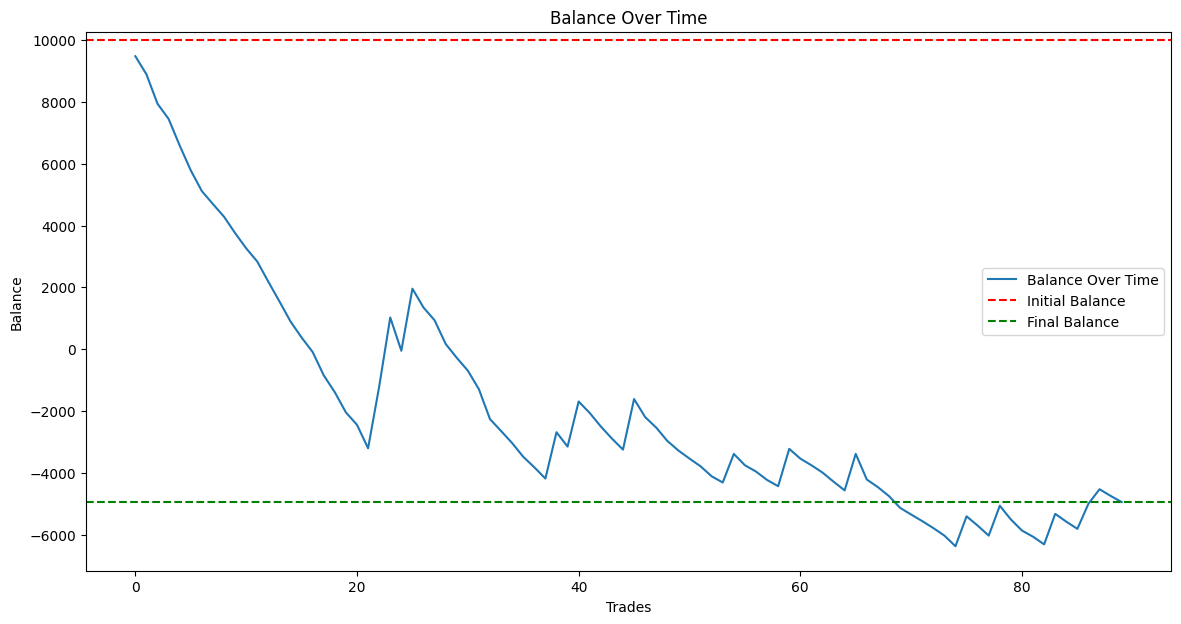

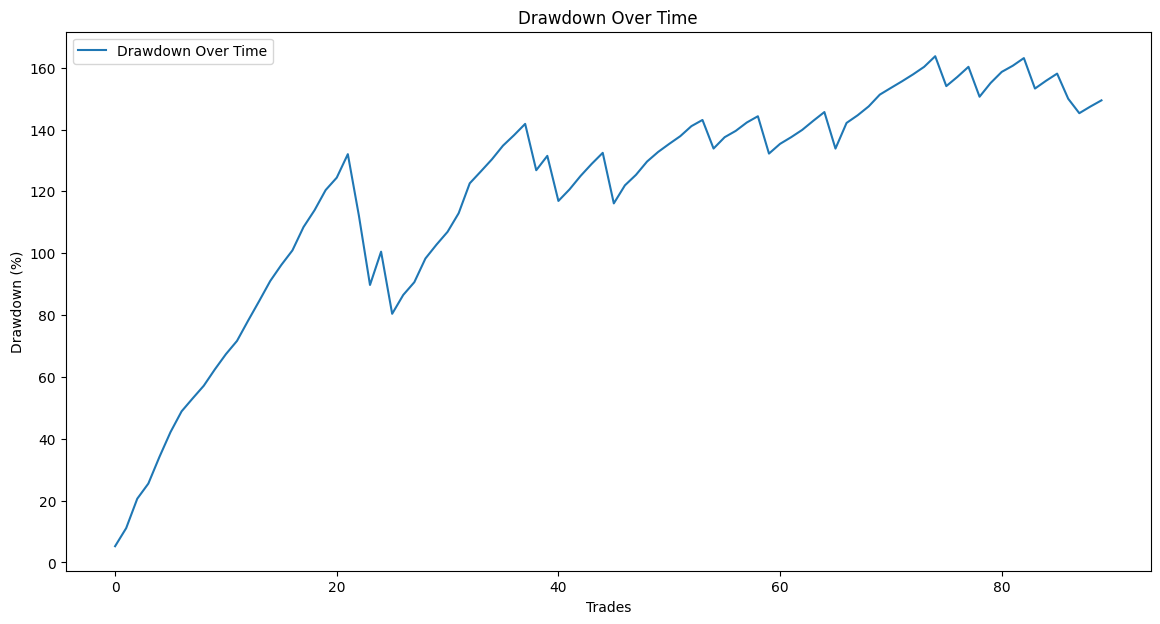

Initial Balance: 10000
Final Balance: -4943.5899999999965
Max Drawdown: 163.71%
Best Trade: Buy at 44392.71, Sell at 46630.4, Profit: 2237.69
Worst Trade: Buy at 39978.15, Sell at 38901.47, Loss: -1076.68


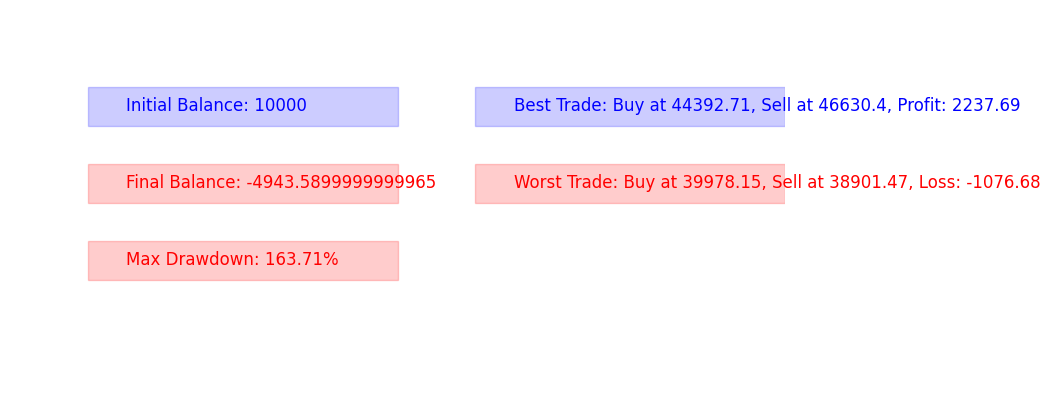

In [264]:
def get_sleep_interval(interval):
    # Convert interval string to minutes
    interval_minutes = int(interval[:-1])
    return interval_minutes * 60

# Choose mode: 'real-time' or 'backtest'
main(mode='backtest')